# Week 3

## Task 1 - Optical flow

### Task 1.1: Optical flow estimation with off-the-shelf method

Quantitative results:
- MSEN: Mean Square Error in Non-occluded areas
- PEPN: Percentage of Erroneous Pixels in Non-occluded areas
- Runtime 

Dataset: Sequences 45 (image_0) from [KITTI](https://www.cvlibs.net/datasets/kitti/eval_stereo_flow.php?benchmark=stereo) (Click "Download stereo/optical flow data set (2 GB)").

In [1]:
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def visualize_flow(img1, img2, u, v, flow):
    """
    Visualize the images and optical flow side by side.

    Parameters:
    - img1: The first image (t) in grayscale.
    - img2: The second image (t+1) in grayscale.
    - u: Horizontal flow components.
    - v: Vertical flow components.
    - flow: Optical flow (u, v) components.

    Returns:
    - None (displays the visualizations using plt.show())
    """
    plt.figure(figsize=(15, 5))

    # Display Image 1 (t)
    plt.subplot(2, 2, 1)
    plt.imshow(img1, cmap='gray')
    plt.title("Image 1 (t)")

    # Display Image 2 (t+1)
    plt.subplot(2, 2, 2)
    plt.imshow(img2, cmap='gray')
    plt.title("Image 2 (t+1)")

    # Downsample for flow visualization (to avoid too many arrows)
    step = 10
    h, w = u.shape
    y, x = np.mgrid[0:h:step, 0:w:step]
    u_down = u[::step, ::step]
    v_down = v[::step, ::step]

    # Display Flow (GT)
    plt.subplot(2, 2, 3)
    plt.imshow(img1, cmap='gray')
    plt.quiver(x, y, u_down, v_down, color='r', angles='xy', scale_units='xy', scale=0.5)
    plt.title("Optical Flow")

    # Prepare flow visualization in HSV
    flow_hsv = np.zeros((img1.shape[0], img1.shape[1], 3), dtype=np.uint8)
    flow_hsv[:, :, 0] = 255  # Set Hue to 255 (will adjust based on angle)
    flow_hsv[:, :, 1] = 255  # Set Saturation to 255 (full saturation)
    
    # Convert flow_gt to magnitude and angle
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    # Map angle (ang) to hue in the range [0, 180]
    flow_hsv[..., 0] = (ang * 180 / np.pi / 2).astype(np.uint8)
    # Normalize magnitude to [0, 255] and use it for the Value channel
    flow_hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    # Convert HSV to RGB
    flow_rgb = cv2.cvtColor(flow_hsv, cv2.COLOR_HSV2BGR)

    # Display Flow visualization in RGB
    plt.subplot(2, 2, 4)
    plt.imshow(flow_rgb, vmin=flow_rgb.min(), vmax=flow_rgb.max())
    plt.title("Optical Flow")

    # Adjust layout and show the figure
    plt.tight_layout()
    plt.show()

In [3]:
def compute_msen(flow_gt, flow_est):
    diff = flow_gt - flow_est
    epe = np.sqrt(np.sum(diff**2, axis=2))
    return np.mean(epe)

def compute_pepn(flow_gt, flow_est, threshold=3.0):
    diff = flow_gt - flow_est
    epe = np.sqrt(np.sum(diff**2, axis=2))
    err_pixels = np.sum(epe > threshold)
    total_pixels = epe.size  
    return 100.0 * err_pixels / total_pixels

In [4]:
# Paths to KITTI data
DATASET_PATH = Path("data_stereo_flow/training/")
IMG_PATH = DATASET_PATH / "image_0"
FLOW_PATH = DATASET_PATH / "flow_occ"
assert DATASET_PATH.exists()
assert IMG_PATH.exists()
assert FLOW_PATH.exists()

# Load images
img1 = cv2.imread(IMG_PATH / "000045_10.png", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(IMG_PATH / "000045_11.png", cv2.IMREAD_GRAYSCALE)

# Load ground truth flow
flow_gt = cv2.imread(FLOW_PATH / "000045_10.png", cv2.IMREAD_UNCHANGED)

# KITTI encodes flow as uint16, need to decode it
u = (flow_gt[:, :, 2].astype(np.float32) - 2**15) / 64.0
v = (flow_gt[:, :, 1].astype(np.float32) - 2**15) / 64.0
flow_gt = np.dstack((u, v))

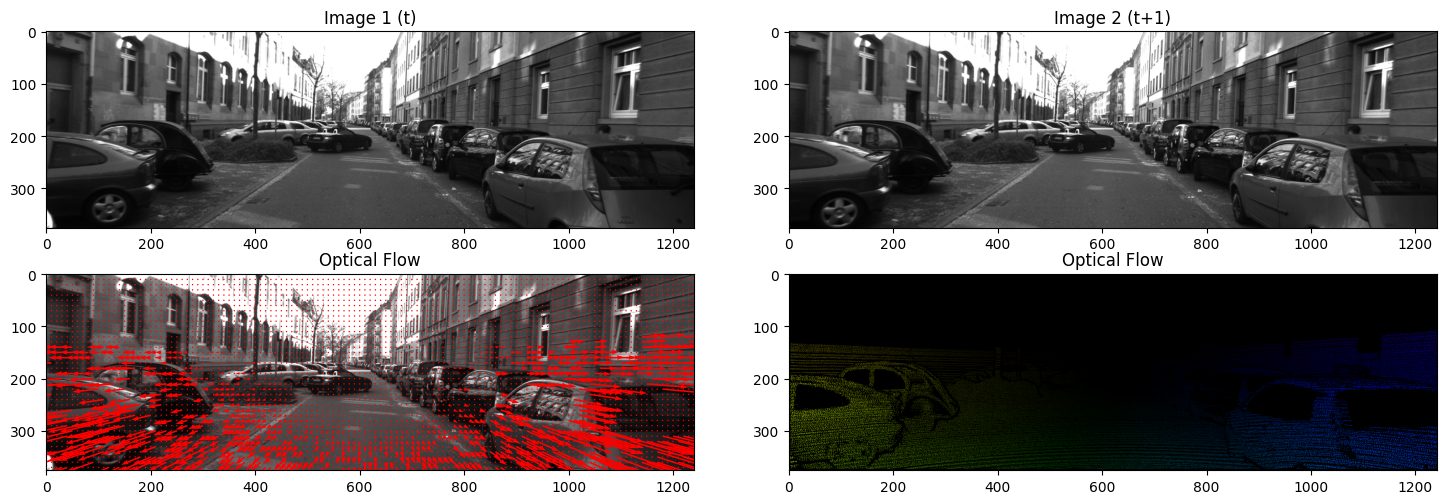

In [5]:
visualize_flow(img1, img2, u, v, flow_gt)

Compute and asses the optical flow provided in [PyFlow](https://github.com/pathak22/pyflow).

In [6]:
from pyflow import pyflow

In [7]:
# Estimate flow using PyFlow
alpha = 0.012
ratio = 0.75
minWidth = 20
nOuterFPIterations = 7
nInnerFPIterations = 1
nSORIterations = 30
colType = 1  # 0 or default:RGB, 1:GRAY (but pass gray image with shape (h,w,1))

u, v, im2W = pyflow.coarse2fine_flow(
    img1[..., np.newaxis].astype(float) / 255., img2[..., np.newaxis].astype(float) / 255.,
    alpha, ratio, minWidth, nOuterFPIterations, nInnerFPIterations,
    nSORIterations, colType
)
flow_est = np.dstack((u, v))

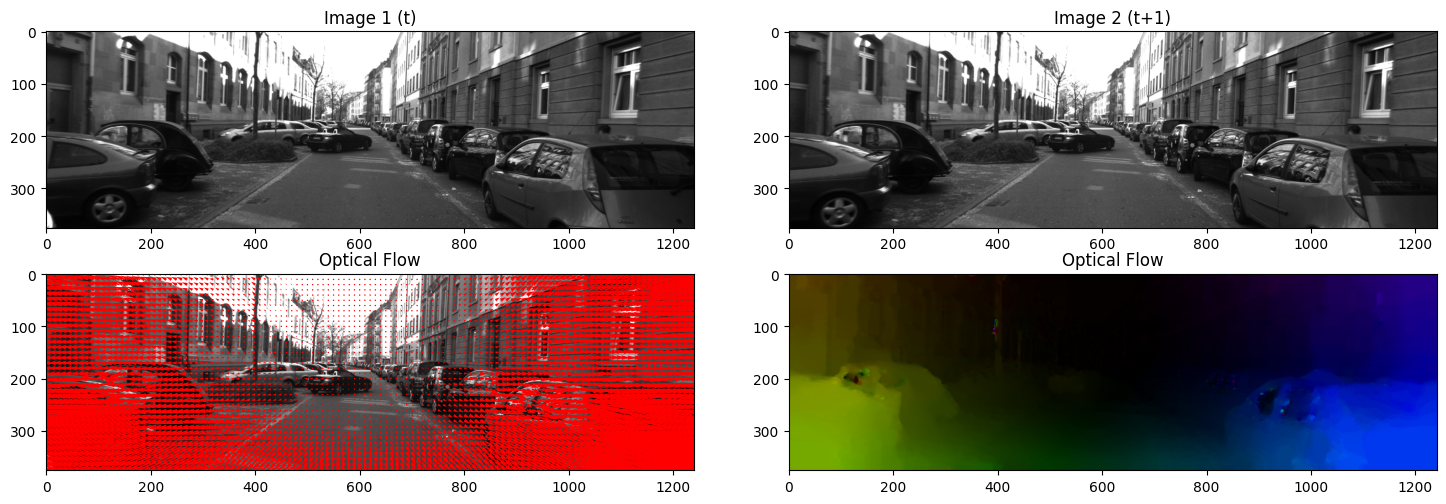

In [8]:
visualize_flow(img1, img2, u, v, flow_est)

In [9]:
# Calculate metrics
msen = compute_msen(flow_gt, flow_est)
pepn = compute_pepn(flow_gt, flow_est)

print(f"MSEN: {msen:.2f}")
print(f"PEPN: {pepn:.2f}%")

MSEN: 9.32
PEPN: 60.33%


Search and asses another optical flow implementation. For each referred technique, specify:
- Citation to the related paper.
- Link to an external implementation or specify if you wrote your own one.

In [10]:
# Estimate flow using Farneback method (non-AI)
flow_est = cv2.calcOpticalFlowFarneback(
    img1, img2, None, 0.5, 3, 15, 3, 5, 1.2, 0
)

# Split the flow into u (horizontal) and v (vertical) components
u, v = flow_est[..., 0], flow_est[..., 1]

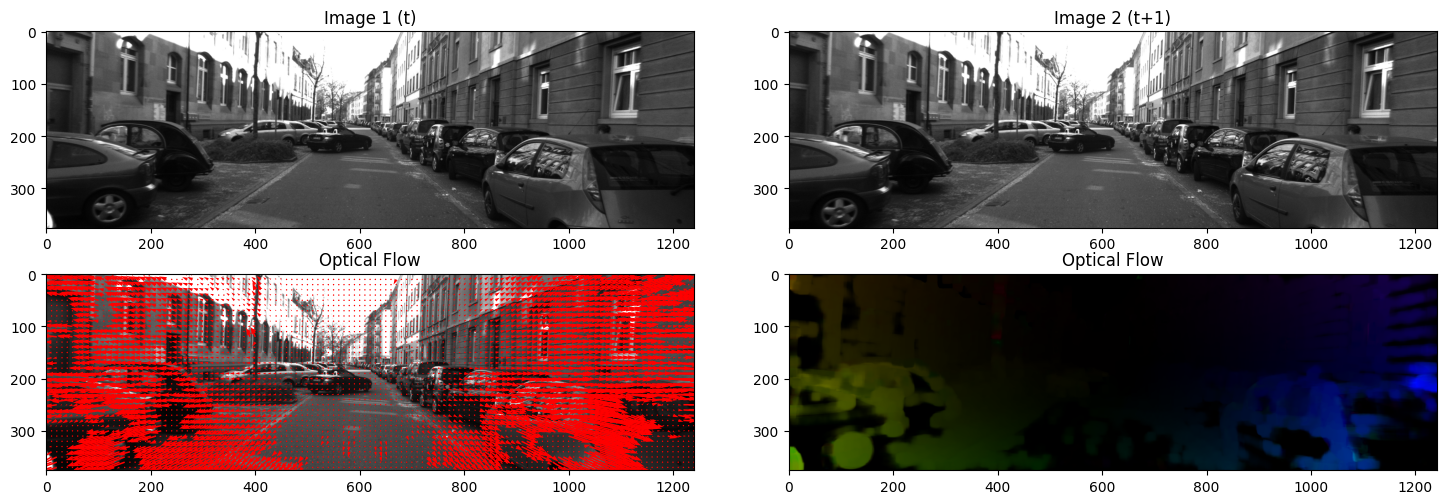

In [11]:
visualize_flow(img1, img2, u, v, flow_est)

In [12]:
# Calculate metrics
msen = compute_msen(flow_gt, flow_est)
pepn = compute_pepn(flow_gt, flow_est)

print(f"MSEN: {msen:.2f}")
print(f"PEPN: {pepn:.2f}%")

MSEN: 7.21
PEPN: 54.95%


In [13]:
import argparse

import torch

from RAFT.core.raft import RAFT
from RAFT.core.utils.utils import InputPadder

DEVICE = 'cpu'

args = argparse.Namespace(small=None, mixed_precision="float", model="RAFT/models/raft-things.pth", path=IMG_PATH.as_posix())

In [14]:
model = torch.nn.DataParallel(RAFT(args))
model.load_state_dict(torch.load(args.model, map_location=torch.device(DEVICE)))

model = model.module
model.to(DEVICE)
model.eval()

RAFT(
  (fnet): BasicEncoder(
    (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (relu1): ReLU(inplace=True)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=Fa

In [15]:
with torch.no_grad():
    # Transform to expected model format
    image1 = torch.from_numpy(np.stack((img1,) * 3, axis=-1)).permute(2, 0, 1).float()[None].to(DEVICE)
    image2 = torch.from_numpy(np.stack((img2,) * 3, axis=-1)).permute(2, 0, 1).float()[None].to(DEVICE)
    
    padder = InputPadder(image1.shape)
    image1, image2 = padder.pad(image1, image2)
    
    flow_low, flow_up = model(image1, image2, iters=20, test_mode=True)

C:\Users\gerar\Documents\MCV\C6\MCV_C6_G7_2025\Week3\RAFT\core\raft.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
C:\Users\gerar\Documents\MCV\C6\MCV_C6_G7_2025\venv\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\gerar\Documents\MCV\C6\MCV_C6_G7_2025\Week3\RAFT\core\raft.py:110: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
C:\Users\gerar\Documents\MCV\C6\MCV_C6_G7_2025\venv\Lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\

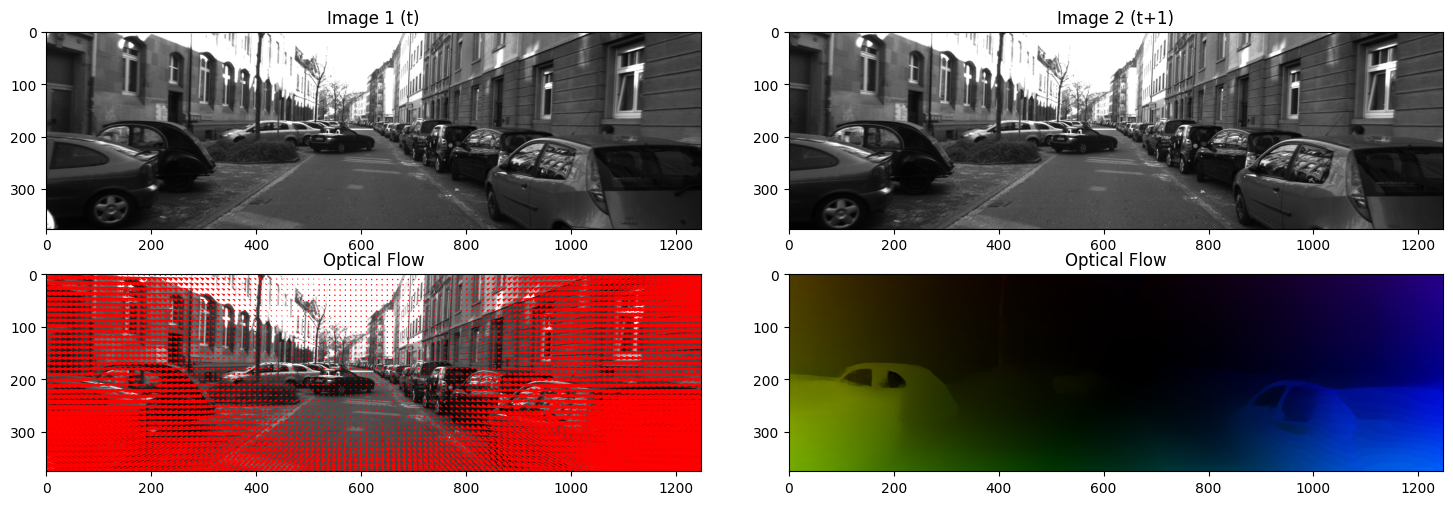

In [16]:
flow_est = flow_up[0].permute(1,2,0).cpu().numpy()

u = flow_est[:,:,0]
v = flow_est[:,:,1]

#viz(image1, flow_up)
visualize_flow(image1[0][0], image2[0][0], u, v, flow_est)

In [17]:
# We need to also pad the gt
flow_gt_padded = padder.pad(torch.from_numpy(flow_gt).permute(2, 0, 1).float())[0].permute(1,2,0).cpu().numpy()

# Calculate metrics
msen = compute_msen(flow_gt_padded, flow_est)
pepn = compute_pepn(flow_gt_padded, flow_est)

print(f"MSEN: {msen:.2f}")
print(f"PEPN: {pepn:.2f}%")

MSEN: 9.52
PEPN: 59.19%
